<a href="https://colab.research.google.com/github/Ashrafalaghbari/capstone_project/blob/main/Univariate_model_single_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%autosave 60

Autosaving every 60 seconds


In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from math import sqrt
import matplotlib.pyplot as plt

In [11]:
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse target variable to its original values (Dataframe)
def inverse_transformation(unscaled_df, col_loc, target, new_max_range=1, new_min_range= -1):
    inverted_var = list()
    unscaled_df= pd.DataFrame(unscaled_df)
    new_range = new_max_range - new_min_range
    for row in range(len(target)):
        org_value = ((max(unscaled_df.iloc[:,col_loc]) -  min(unscaled_df.iloc[:,col_loc]))  * (abs(new_min_range) + target[row])  + (new_range * min(unscaled_df.iloc[:,col_loc]))) / new_range
        inverted_var.append(org_value)
    return np.array(inverted_var)

# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]


In [12]:
#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #adjusted MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2* result/ len(actual) 
    return result * 100

In [13]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', usecols=["DATEPRD","BORE_OIL_VOL"],
                  parse_dates=["DATEPRD"], index_col="DATEPRD")
series["constant"] = 1

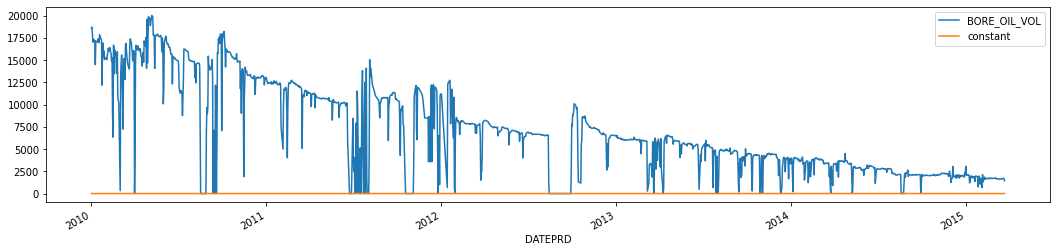

In [14]:
series.plot.line(figsize=(18,4))
plt.show()

In [15]:
# convert series to stationary
series_diff =  series.diff()
# convert the stationary series to embeddings
timesteps = 5
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in=timesteps, n_out=1, dropnan=True)
# drop columns we don't want to predict
series_supervised.drop([ "constant(t)"], axis=1, inplace=True)
series_supervised = series_supervised.values

In [16]:
# split into train and test sets
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print(train.shape, test.shape)

(1470, 11) (368, 11)


In [17]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(train_scaled.shape, test_scaled.shape)

(1470, 11) (368, 11)


In [18]:
# reshape input to be 3D [samples, timesteps, features]
n_features = len(series.columns)

train_X, train_y = train_scaled[:, 0:-1], train_scaled[:, -1]
train_X = train_X.reshape(train_X.shape[0], timesteps, n_features )
test_X, test_y = test_scaled[:, 0:-1], test_scaled[:, -1]
test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1470, 5, 2) (1470,) (368, 5, 2) (368,)


In [19]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

# fit the model
neurons= [4] 
n_epochs=18
batch_size=1

model = Sequential()
model.add(LSTM(neurons[0], batch_input_shape=(batch_size, timesteps, n_features), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.reset_states()

Epoch 1/18
1470/1470 - 6s - loss: 0.0250 - val_loss: 3.0364e-04 - 6s/epoch - 4ms/step
Epoch 2/18
1470/1470 - 4s - loss: 0.0084 - val_loss: 3.4323e-04 - 4s/epoch - 2ms/step
Epoch 3/18
1470/1470 - 3s - loss: 0.0060 - val_loss: 2.9249e-04 - 3s/epoch - 2ms/step
Epoch 4/18
1470/1470 - 3s - loss: 0.0055 - val_loss: 2.8308e-04 - 3s/epoch - 2ms/step
Epoch 5/18
1470/1470 - 3s - loss: 0.0054 - val_loss: 2.8137e-04 - 3s/epoch - 2ms/step
Epoch 6/18
1470/1470 - 4s - loss: 0.0053 - val_loss: 2.7751e-04 - 4s/epoch - 2ms/step
Epoch 7/18
1470/1470 - 3s - loss: 0.0052 - val_loss: 2.7488e-04 - 3s/epoch - 2ms/step
Epoch 8/18
1470/1470 - 4s - loss: 0.0052 - val_loss: 2.7298e-04 - 4s/epoch - 2ms/step
Epoch 9/18
1470/1470 - 4s - loss: 0.0052 - val_loss: 2.7525e-04 - 4s/epoch - 2ms/step
Epoch 10/18
1470/1470 - 4s - loss: 0.0051 - val_loss: 2.6833e-04 - 4s/epoch - 2ms/step
Epoch 11/18
1470/1470 - 3s - loss: 0.0051 - val_loss: 2.6621e-04 - 3s/epoch - 2ms/step
Epoch 12/18
1470/1470 - 4s - loss: 0.0051 - val_loss

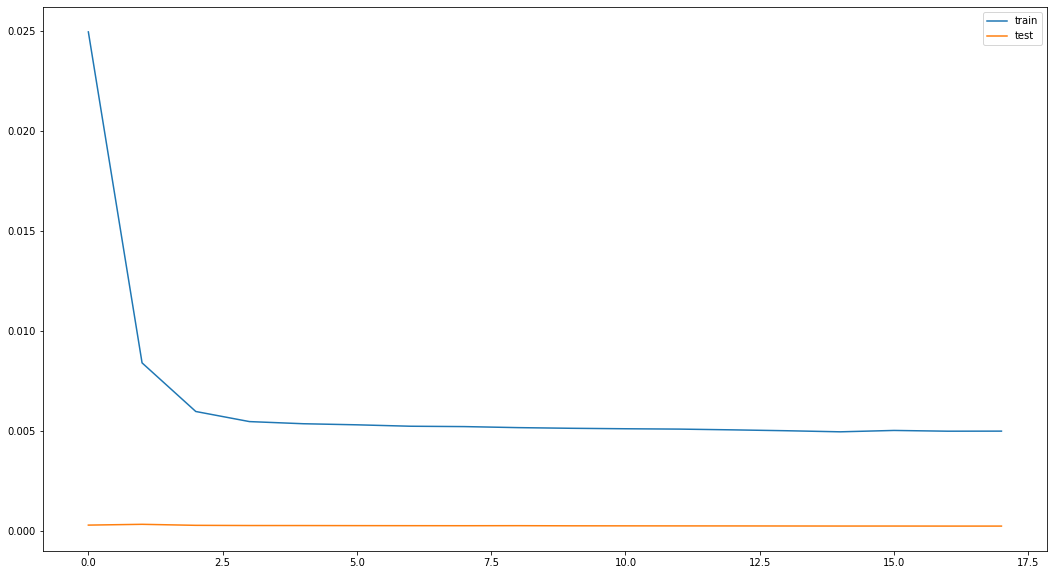

In [20]:
plt.figure(figsize=(18,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
# make a prediction 
yhat = model.predict(test_X, batch_size)

# # invert scaling for actual
inv_y = inverse_transformation(series_supervised, -1, test_y, new_max_range=1, new_min_range= 0)

# #  Inverse of Differencing for actual 
test_y_org  = inverse_difference(series.values)
test_y_org = test_y_org[:,0]
inv_y = np.add(inv_y,test_y_org)

# # invert scaling for forecast
inv_yhat = inverse_transformation(series_supervised, -1, yhat, new_max_range=1, new_min_range= 0)

# #  Inverse of Differencing for forecast
inv_yhat = np.add(inv_yhat ,  test_y_org.reshape(-1,1))

# #return the same shape for another prediction trial
test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))

368/368 [==============================] - 1s 2ms/step


In [22]:
# Performance evaluation

rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
RMSPE_test = RMSPE(inv_y, inv_yhat)
print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.5f' % MAE_test)
MAPE_test = MAPE(inv_y, inv_yhat)
print('Test MAPE: %.5f' % MAPE_test)
r2 = r2_score(inv_y, inv_yhat)
print('Test r2: %.5f' % r2)
wMAPE_test = wMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % wMAPE_test)
SMAPE_test = SMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % SMAPE_test)

Test RMSE: 460.82027
Test RMSPE: 8107448285797567.00000
Test MAE: 209.12265
Test MAPE: 707479466291251.62500
Test r2: 0.58813
Test wMAPE: 9.33210 
Test wMAPE: 14.50280 


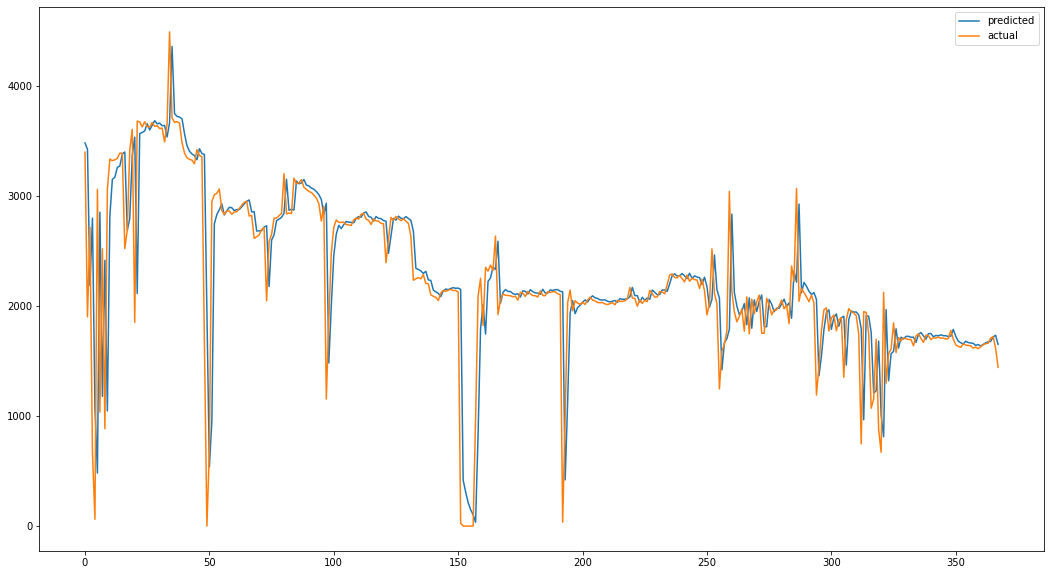

In [23]:
plt.figure(figsize=(18,10))
plt.plot(inv_yhat, label = "predicted")
plt.plot(inv_y, label = "actual")
plt.legend()
plt.show()

In [24]:
#comparing predictions and actual values
act_pred = pd.DataFrame({"actual":inv_y, "prediction":inv_yhat.squeeze()})
act_pred.tail(20)

,actual,prediction
348,1779.450317,1727.176262
349,1699.947111,1788.431762
350,1647.678785,1725.333830
351,1634.029896,1682.079175
352,1625.978938,1667.221302
353,1656.987704,1656.856868
354,1646.106332,1680.831454
355,1643.024325,1669.072152
356,1639.439133,1664.922762
357,1618.116675,1661.387375
